In [7]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()
    
def save_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), name='image.png'):
    path = "floor_runs/"
    # naming convention: floors/runs/epoch_step.png
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.savefig(path + name)
    plt.close()

def crop(image, new_shape):
    middle_height = image.shape[2] // 2
    middle_width = image.shape[3] // 2
    starting_height = middle_height - round(new_shape[2] / 2)
    final_height = starting_height + new_shape[2]
    starting_width = middle_width - round(new_shape[3] / 2)
    final_width = starting_width + new_shape[3]
    cropped_image = image[:, :, starting_height:final_height, starting_width:final_width]
    return cropped_image

In [2]:
class ContractingBlock(nn.Module):
    def __init__(self, input_channels, use_dropout=False, use_bn=True):
        super(ContractingBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels * 2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(input_channels * 2, input_channels * 2, kernel_size=3, padding=1)
        self.activation = nn.LeakyReLU(0.2)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        if use_bn:
            self.batchnorm = nn.BatchNorm2d(input_channels * 2)
        self.use_bn = use_bn
        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout

    def forward(self, x):
        x = self.conv1(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.conv2(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.maxpool(x)
        return x

class ExpandingBlock(nn.Module):
    def __init__(self, input_channels, use_dropout=False, use_bn=True):
        super(ExpandingBlock, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=2)
        self.conv2 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(input_channels // 2, input_channels // 2, kernel_size=2, padding=1)
        if use_bn:
            self.batchnorm = nn.BatchNorm2d(input_channels // 2)
        self.use_bn = use_bn
        self.activation = nn.ReLU()
        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout

    def forward(self, x, skip_con_x):
        x = self.upsample(x)
        x = self.conv1(x)
        skip_con_x = crop(skip_con_x, x.shape)
        x = torch.cat([x, skip_con_x], axis=1)
        x = self.conv2(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.conv3(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        return x

class FeatureMapBlock(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=1)

    def forward(self, x):
        x = self.conv(x)
        return x

class UNet(nn.Module):
    def __init__(self, input_channels, output_channels, hidden_channels=32):
        super(UNet, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_dropout=True)
        self.contract2 = ContractingBlock(hidden_channels * 2, use_dropout=True)
        self.contract3 = ContractingBlock(hidden_channels * 4, use_dropout=True)
        self.contract4 = ContractingBlock(hidden_channels * 8)
        self.contract5 = ContractingBlock(hidden_channels * 16)
        self.contract6 = ContractingBlock(hidden_channels * 32)
        self.expand0 = ExpandingBlock(hidden_channels * 64)
        self.expand1 = ExpandingBlock(hidden_channels * 32)
        self.expand2 = ExpandingBlock(hidden_channels * 16)
        self.expand3 = ExpandingBlock(hidden_channels * 8)
        self.expand4 = ExpandingBlock(hidden_channels * 4)
        self.expand5 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        x5 = self.contract5(x4)
        x6 = self.contract6(x5)
        x7 = self.expand0(x6, x5)
        x8 = self.expand1(x7, x4)
        x9 = self.expand2(x8, x3)
        x10 = self.expand3(x9, x2)
        x11 = self.expand4(x10, x1)
        x12 = self.expand5(x11, x0)
        xn = self.downfeature(x12)
        return self.sigmoid(xn)

In [3]:
class Discriminator(nn.Module):
    def __init__(self, input_channels, hidden_channels=8):
        super(Discriminator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_bn=False)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        self.contract3 = ContractingBlock(hidden_channels * 4)
        self.contract4 = ContractingBlock(hidden_channels * 8)
        self.final = nn.Conv2d(hidden_channels * 16, 1, kernel_size=1)

    def forward(self, x, y):
        x = torch.cat([x, y], axis=1)
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        xn = self.final(x4)
        return xn

In [4]:
import torch.nn.functional as F

# mess with them if you understand them else leave them as is
adv_criterion = nn.BCEWithLogitsLoss() 
recon_criterion = nn.L1Loss() 
lambda_recon = 200

# You can mess with these hyperparameters, no marks will be deducted its just for fun
n_epochs = 200
input_dim = 3
real_dim = 3
display_step = 200
batch_size = 4
lr = 0.0002
target_shape = 256
device = 'cpu'

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

import torchvision
# folder path mentioned here should have a train and test folder with the images inside them, ImageFolder will automatically label the images based on the folder name
dataset = torchvision.datasets.ImageFolder("floors", transform=transform)

In [6]:
gen = UNet(input_dim, real_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(input_dim + real_dim).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

# Keep this True if you want to see quick results, set to False if you want to train the model from scratch
pretrained = False

if pretrained:
    loaded_state = torch.load("pix2pix_15000.pth")
    gen.load_state_dict(loaded_state["gen"])
    gen_opt.load_state_dict(loaded_state["gen_opt"])
    disc.load_state_dict(loaded_state["disc"])
    disc_opt.load_state_dict(loaded_state["disc_opt"])
else:
    gen = gen.apply(weights_init)
    disc = disc.apply(weights_init)

In [7]:
def get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon):
    fake = gen(condition)
    disc_fake_hat = disc(fake, condition)
    gen_adv_loss = adv_criterion(disc_fake_hat, torch.ones_like(disc_fake_hat))
    gen_rec_loss = recon_criterion(real, fake)
    gen_loss = gen_adv_loss + lambda_recon * gen_rec_loss
    return gen_loss

  0%|          | 0/15 [00:00<?, ?it/s]

Pretrained initial state


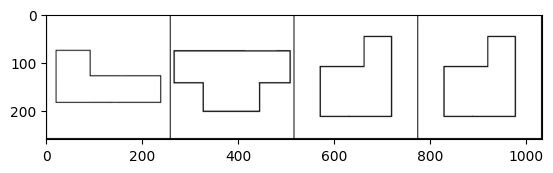

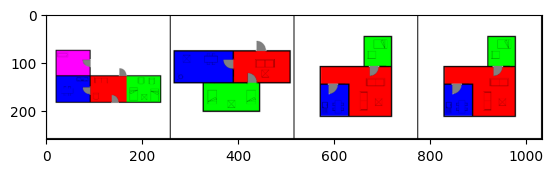

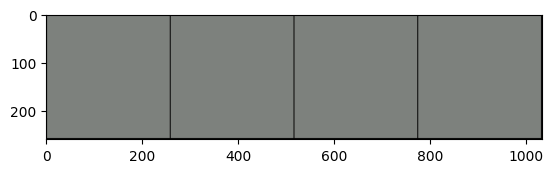

  7%|▋         | 1/15 [00:22<05:18, 22.75s/it]


KeyboardInterrupt: 

In [8]:
# from skimage import color
import numpy as np

def train(save_model=False):
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    cur_step = 0
    for epoch in range(n_epochs):
        for image, _ in tqdm(dataloader):
            image_width = image.shape[3]
            condition = image[:, :, :, :image_width // 2]
            condition = nn.functional.interpolate(condition, size=(target_shape, target_shape), mode='bilinear')
            real = image[:, :, :, image_width // 2:]
            real = nn.functional.interpolate(real, size=(target_shape, target_shape), mode='bilinear')
            cur_batch_size = len(condition)
            condition = condition.to(device)
            real = real.to(device)

            # Ensure condition and real have the same spatial dimensions before concatenation
            if condition.shape[2:] != real.shape[2:]:
                raise ValueError("Condition and real tensors must have the same spatial dimensions.")

            ### Update discriminator ###
            disc_opt.zero_grad()
            with torch.no_grad():
                fake = gen(condition)
            disc_fake_hat = disc(fake.detach(), condition)
            disc_fake_loss = adv_criterion(disc_fake_hat, torch.zeros_like(disc_fake_hat))
            disc_real_hat = disc(real, condition)
            disc_real_loss = adv_criterion(disc_real_hat, torch.ones_like(disc_real_hat))
            disc_loss = (disc_fake_loss + disc_real_loss) / 2
            disc_loss.backward(retain_graph=True)
            disc_opt.step()
            ### Update generator ###
            gen_opt.zero_grad()
            gen_loss = get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon)
            gen_loss.backward()
            gen_opt.step()

            # Keep track of the average discriminator loss
            mean_discriminator_loss += disc_loss.item() / display_step
            # Keep track of the average generator loss
            mean_generator_loss += gen_loss.item() / display_step

            ### Visualization code ###
            if cur_step % display_step == 0:
                if cur_step > 0:
                    print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
                else:
                    print("Pretrained initial state")
                show_tensor_images(condition, size=(input_dim, target_shape, target_shape))
                save_tensor_images(condition, size=(input_dim, target_shape, target_shape), name=f"{epoch}condition_{cur_step}.png")
                show_tensor_images(real, size=(real_dim, target_shape, target_shape))
                save_tensor_images(real, size=(real_dim, target_shape, target_shape), name=f"{epoch}real_{cur_step}.png")
                show_tensor_images(fake, size=(real_dim, target_shape, target_shape))
                save_tensor_images(fake, size=(real_dim, target_shape, target_shape), name=f"{epoch}fake_{cur_step}.png")
                mean_generator_loss = 0
                mean_discriminator_loss = 0
                if save_model:
                    torch.save({'gen': gen.state_dict(),
                        'gen_opt': gen_opt.state_dict(),
                        'disc': disc.state_dict(),
                        'disc_opt': disc_opt.state_dict()
                    }, f"pix2pix_{cur_step}.pth")
            cur_step += 1
train()

In [ ]:
# save the model in pth format using torch.save
torch.save({'gen': gen.state_dict(),
            'gen_opt': gen_opt.state_dict(),
            'disc': disc.state_dict(),
            'disc_opt': disc_opt.state_dict()
            }, 'pix2pix_floors_colored'+str(n_epochs)+'.pth')

In [ ]:
 use the segmentaion models pytorch library @ to replicate the older code for a pix2pix gan but in this version use the pretrained UNET from the library and an appropriate discriminator and training loop, take refernece from the code in the cells that are not commented to get an ide of how data is iongested and used to train the model 

  0%|          | 0/58 [00:00<?, ?it/s]

Pretrained initial state


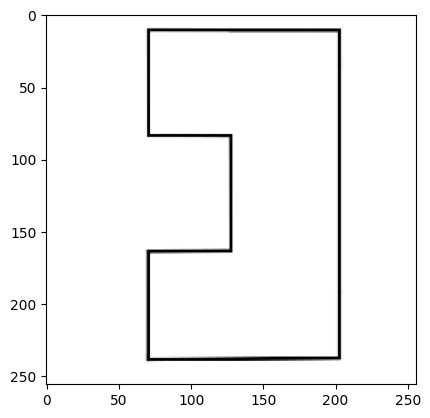

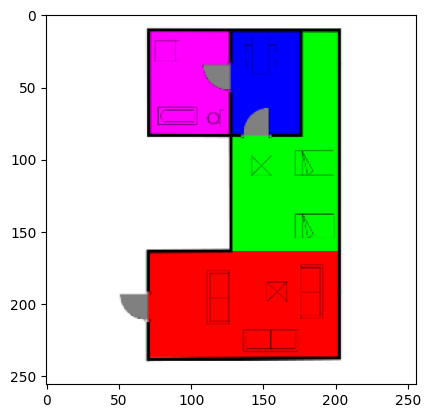

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-11.574097..5.327496].


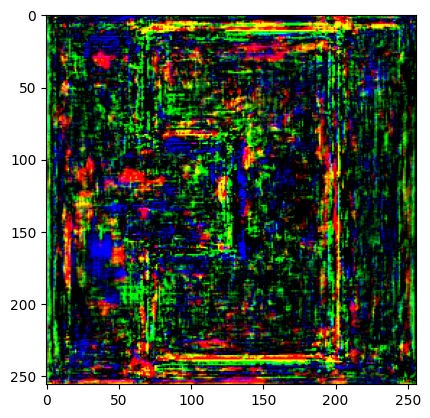

 62%|██████▏   | 36/58 [00:19<00:12,  1.71it/s]

Epoch 8: Step 500: Generator (U-Net) loss: 114.66770960998534, Discriminator loss: 0.01970850457740014


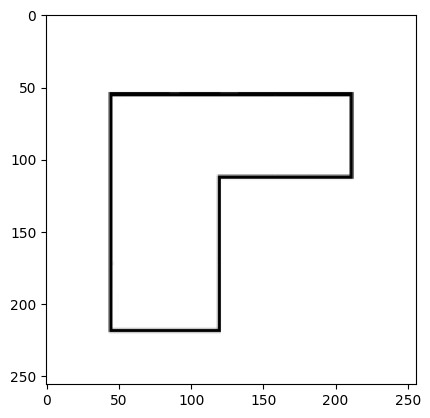

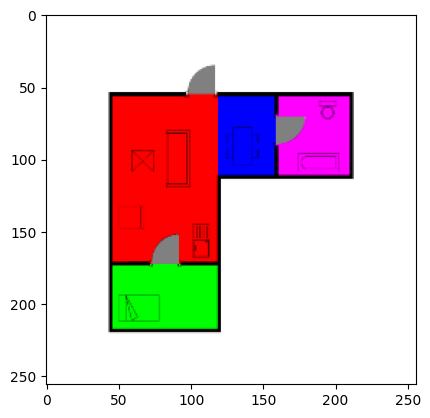

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-10.718642..5.248343].


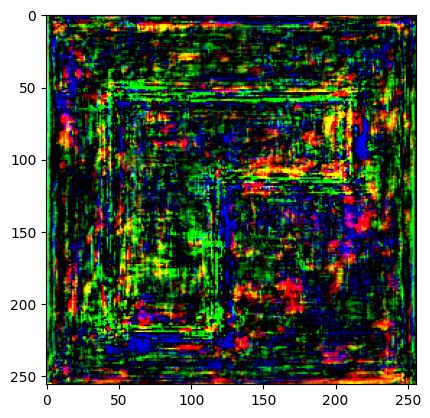

100%|██████████| 58/58 [00:44<00:00,  1.31it/s]


In [ ]:
# import segmentation_models_pytorch as smp
# import torchvision
# import torch
# from torch import nn
# from tqdm.auto import tqdm
# from torchvision import transforms
# from torchvision.utils import make_grid
# from torch.utils.data import DataLoader
# import matplotlib.pyplot as plt

# transform = torchvision.transforms.Compose([
#     transforms.ToTensor(),
# ])

# # folder path mentioned here should have a train and test folder with the images inside them, ImageFolder will automatically label the images based on the folder name
# dataset = torchvision.datasets.ImageFolder("floors", transform=transform)

# # Create pretrained UNet generator
# gen = smp.Unet(
#     encoder_name="resnet34",        # Use ResNet34 backbone
#     encoder_weights="imagenet",     # Use pretrained weights
#     in_channels=3,                  # Input channels (condition image)
#     classes=3,                      # Output channels (generated image)
# )

# # Custom PatchGAN discriminator
# class Discriminator(nn.Module):
#     def __init__(self, in_channels=6):  # 6 channels (3 real/fake + 3 condition)
#         super().__init__()
        
#         def discriminator_block(in_channels, out_channels, stride=2, norm=True):
#             layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=stride, padding=1, bias=False)]
#             if norm:
#                 layers.append(nn.BatchNorm2d(out_channels))
#             layers.append(nn.LeakyReLU(0.2))
#             return layers

#         self.model = nn.Sequential(
#             *discriminator_block(in_channels, 64, norm=False),  # (bs, 64, 128, 128)
#             *discriminator_block(64, 128),                      # (bs, 128, 64, 64)
#             *discriminator_block(128, 256),                     # (bs, 256, 32, 32)
#             *discriminator_block(256, 512, stride=1),           # (bs, 512, 31, 31)
#             nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)  # (bs, 1, 30, 30)
#         )

#     def forward(self, x, y):
#         return self.model(torch.cat([x, y], dim=1))

# # Initialize models and optimizers
# disc = Discriminator()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# gen = gen.to(device)
# disc = disc.to(device)

# # Loss functions
# adv_criterion = nn.BCEWithLogitsLoss()
# recon_criterion = nn.L1Loss()

# # Optimizers
# gen_opt = torch.optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
# disc_opt = torch.optim.Adam(disc.parameters(), lr=0.0002, betas=(0.5, 0.999))

# def train(n_epochs=15, display_step=500, batch_size=1, target_shape=256, lambda_recon=100, save_model=True):
#     dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
#     cur_step = 0
#     mean_generator_loss = 0
#     mean_discriminator_loss = 0
    
#     for epoch in range(n_epochs):
#         for image, _ in tqdm(dataloader):
#             image_width = image.shape[3]
#             condition = image[:, :, :, :image_width // 2]
#             condition = nn.functional.interpolate(condition, size=(target_shape, target_shape), mode='bilinear')
#             real = image[:, :, :, image_width // 2:]
#             real = nn.functional.interpolate(real, size=(target_shape, target_shape), mode='bilinear')
#             cur_batch_size = len(condition)
#             condition = condition.to(device)
#             real = real.to(device)

#             ### Update discriminator ###
#             disc_opt.zero_grad()
#             with torch.no_grad():
#                 fake = gen(condition)
            
#             disc_fake_hat = disc(fake.detach(), condition) 
#             disc_fake_loss = adv_criterion(disc_fake_hat, torch.zeros_like(disc_fake_hat))
#             disc_real_hat = disc(real, condition)
#             disc_real_loss = adv_criterion(disc_real_hat, torch.ones_like(disc_real_hat))
#             disc_loss = (disc_fake_loss + disc_real_loss) / 2
#             disc_loss.backward()
#             disc_opt.step()

#             ### Update generator ###
#             gen_opt.zero_grad()
#             gen_fake_hat = disc(fake, condition)
#             gen_adv_loss = adv_criterion(gen_fake_hat, torch.ones_like(gen_fake_hat))
#             gen_recon_loss = recon_criterion(fake, real) * lambda_recon
#             gen_loss = gen_adv_loss + gen_recon_loss
#             gen_loss.backward()
#             gen_opt.step()

#             # Keep track of the average losses
#             mean_discriminator_loss += disc_loss.item() / display_step
#             mean_generator_loss += gen_loss.item() / display_step

#             ### Visualization code ###
#             if cur_step % display_step == 0:
#                 if cur_step > 0:
#                     print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
#                 else:
#                     print("Pretrained initial state")
#                 show_tensor_images(condition, size=(3, 256, 256))
#                 show_tensor_images(real, size=(3, 256, 256))
#                 show_tensor_images(fake, size=(3, 256, 256))
#                 mean_generator_loss = 0
#                 mean_discriminator_loss = 0
                
#                 if save_model:
#                     torch.save({
#                         'gen': gen.state_dict(),
#                         'gen_opt': gen_opt.state_dict(),
#                         'disc': disc.state_dict(),
#                         'disc_opt': disc_opt.state_dict()
#                     }, f"pix2pix_{cur_step}.pth")
#             cur_step += 1

# # Train the model
# train()


